In [1]:
from qdrant_client import QdrantClient

client = QdrantClient(url="http://localhost:6333")

points = client.retrieve(
    collection_name="log_sessions",
    ids=[0],  # any point id
    with_vectors=True,
    with_payload=True,
)

print("Payload:", points[0].payload)
print("Vector dim:", len(points[0].vector))
print("Vector (first 10):", points[0].vector[:10])

Payload: {'session_id': '00003c7f-42a8-5b1b-ae4b-8d41700c9c36', 'src_ip': '127.0.0.1', 'tool': 'browser/unknown', 'label': 'benign', 'suspicious_score': 0.00804680291356217, 'event_count': 1, 'rps': 1.0, 'indicator_hits': 0, 'start_ts': '2023-08-10T10:37:02+00:00', 'end_ts': '2023-08-10T10:37:02+00:00'}
Vector dim: 1024
Vector (first 10): [-0.03937248, 0.022991484, 0.037090432, -0.023892926, -0.013544865, 0.019359961, -0.0036483211, 0.019046899, 0.005694689, 0.002977484]


In [2]:
import numpy as np
from qdrant_client import QdrantClient

client = QdrantClient(url="http://localhost:6333")

# Scroll points (limit for demo)
points, _ = client.scroll(
    collection_name="log_sessions",
    limit=500,  # keep small for t-SNE
    with_vectors=True,
    with_payload=True,
)

X = np.array([p.vector for p in points])
labels = [p.payload.get("label", "unknown") for p in points]

X.shape

(500, 1024)

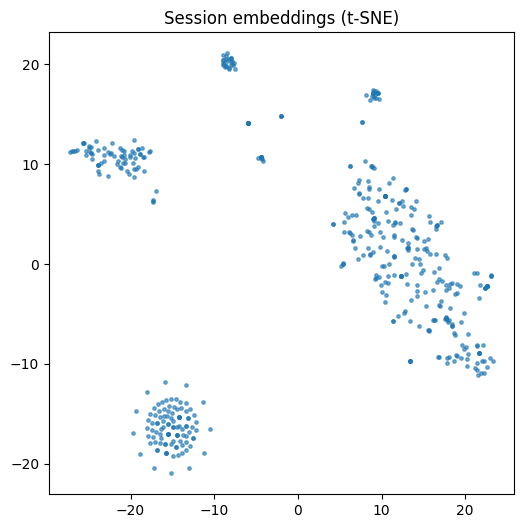

In [3]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

X_2d = TSNE(
    n_components=2, perplexity=30, learning_rate="auto", init="random", random_state=42
).fit_transform(X)

plt.figure(figsize=(6, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], s=6, alpha=0.6)
plt.title("Session embeddings (t-SNE)")
plt.show()

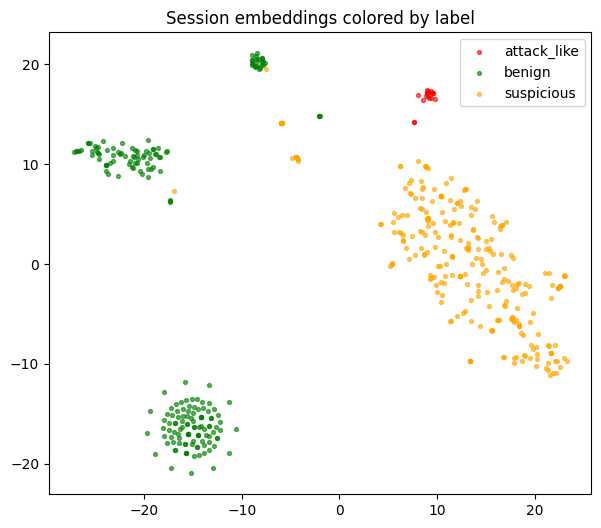

In [4]:
import pandas as pd

color_map = {
    "benign": "green",
    "attack_like": "red",
    "suspicious": "orange",
}

df = pd.DataFrame(X_2d, columns=["x", "y"])
df["label"] = labels

plt.figure(figsize=(7, 6))
for lbl, g in df.groupby("label"):
    plt.scatter(g.x, g.y, s=8, alpha=0.6, label=lbl, color=color_map.get(lbl, "gray"))

plt.legend()
plt.title("Session embeddings colored by label")
plt.show()

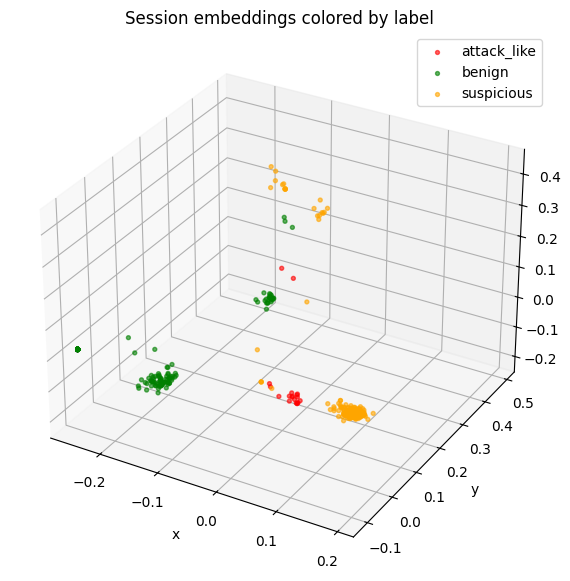

In [5]:
from sklearn.decomposition import PCA

color_map = {
    "benign": "green",
    "attack_like": "red",
    "suspicious": "orange",
}

# X is your original high‑dim embeddings (e.g., 384 dims)
X_3d = PCA(n_components=3, random_state=42).fit_transform(X)

df = pd.DataFrame(X_3d, columns=["x", "y", "z"])
df["label"] = labels

fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection="3d")

for lbl, g in df.groupby("label"):
    ax.scatter(
        g.x, g.y, g.z, s=8, alpha=0.6, label=lbl, color=color_map.get(lbl, "gray")
    )

ax.set_title("Session embeddings colored by label")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.legend()
plt.show()

In [6]:
client = QdrantClient(url="http://localhost:6333")

cols = client.get_collections().collections
[c.name for c in cols]
for name in ["mitre_attack", "log_sessions"]:
    info = client.get_collection(name)
    print(
        name, "| points:", info.points_count, "| vectors:", info.config.params.vectors
    )

mitre_attack | points: 835 | vectors: size=1024 distance=<Distance.COSINE: 'Cosine'> hnsw_config=None quantization_config=None on_disk=None datatype=None multivector_config=None
log_sessions | points: 53558 | vectors: size=1024 distance=<Distance.COSINE: 'Cosine'> hnsw_config=None quantization_config=None on_disk=None datatype=None multivector_config=None


In [7]:
# run attack
from src.rag.retrieve import search_attack_for_text

hits = search_attack_for_text(
    "directory brute force enumeration gobuster scanning",
    top_k=10,
    embed_model="BAAI/bge-large-en-v1.5",
    device="auto",
)

for h in hits[:10]:
    p = h.payload
    print(
        f"{h.score:.3f}  {p['technique_id']}  {p['name']}  tactics={p.get('tactics')}"
    )

d:\VScode\isea-rag-attack-classification\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🔧 Embeddings device selected: cpu


Loading weights: 100%|██████████| 391/391 [00:01<00:00, 373.58it/s, Materializing param=pooler.dense.weight]                               
RobertaModel LOAD REPORT from: BAAI/bge-large-en-v1.5
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Batches: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


0.439  T1083  File and Directory Discovery  tactics=['discovery']
0.384  T1564.012  File/Path Exclusions  tactics=['defense-evasion']
0.375  T1595.003  Wordlist Scanning  tactics=['reconnaissance']
0.374  T1560.001  Archive via Utility  tactics=['collection']
0.365  T1005  Data from Local System  tactics=['collection']
0.351  T1110  Brute Force  tactics=['credential-access']
0.346  T1518.002  Backup Software Discovery  tactics=['discovery']
0.340  T1140  Deobfuscate/Decode Files or Information  tactics=['defense-evasion']
0.339  T1222.002  Linux and Mac File and Directory Permissions Modification  tactics=['defense-evasion']
0.330  T1025  Data from Removable Media  tactics=['collection']


In [8]:
import pandas as pd
from src.rag.retrieve import search_sessions

hits = search_sessions(
    "etc passwd traversal lfi attempt",
    top_k=10,
    label="attack_like",  # try "suspicious" too
    tool="gobuster",  # or None
    embed_model="BAAI/bge-large-en-v1.5",
    device="auto",
)

rows = []
for h in hits:
    p = h.payload
    rows.append(
        {
            "score": round(h.score, 3),
            "session_id": p.get("session_id"),
            "src_ip": p.get("src_ip"),
            "label": p.get("label"),
            "tool": p.get("tool"),
            "suspicious_score": p.get("suspicious_score"),
            "event_count": p.get("event_count"),
            "start_ts": p.get("start_ts"),
        }
    )

pd.DataFrame(rows)

🔧 Embeddings device selected: cpu


Loading weights: 100%|██████████| 391/391 [00:01<00:00, 305.66it/s, Materializing param=pooler.dense.weight]                               
RobertaModel LOAD REPORT from: BAAI/bge-large-en-v1.5
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Batches: 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


,score,session_id,src_ip,label,tool,suspicious_score,event_count,start_ts
0,0.259,d9a0d430-4385-554e-999d-04622b5d9209,49.34.106.190,attack_like,gobuster,0.843943,8,2023-01-09T10:04:12+00:00
1,0.256,743a9a34-bceb-533a-8fc3-8c30639337d3,199.188.238.77,attack_like,gobuster,0.954495,115716,2024-02-09T13:58:36+00:00
2,0.256,5d506a84-dfcc-59a2-bfee-c802f6ae90fd,106.205.210.163,attack_like,gobuster,0.954085,9184,2024-01-19T06:51:06+00:00
3,0.251,0bd19db5-97b8-527d-a725-fd5303b6ca5c,103.111.33.197,attack_like,gobuster,0.955026,309913,2024-02-09T15:19:23+00:00
4,0.251,040cce28-ec86-509f-a3cc-5a3142b750e2,152.58.39.230,attack_like,gobuster,0.838871,2,2024-01-19T02:34:38+00:00
5,0.251,c798b7df-827a-5c8f-87fe-3500dee82922,106.205.210.163,attack_like,gobuster,0.951415,4603,2024-01-19T05:25:27+00:00
6,0.251,4ec55fc7-576d-5250-ada7-e130d988bb6b,143.244.44.163,attack_like,gobuster,0.954422,20407,2024-01-24T08:46:52+00:00
7,0.250,50098038-418c-5415-a6d8-7440a07bb979,88.216.90.156,attack_like,gobuster,0.955263,5869,2024-02-08T11:59:19+00:00
8,0.250,1e5d31e9-50bd-54a1-85fe-e2df078ab6ff,152.58.34.93,attack_like,gobuster,0.838871,2,2024-01-30T07:53:39+00:00
9,0.247,fead1d1b-9bde-528b-a63b-c77e622d97ae,152.58.39.168,attack_like,gobuster,0.950005,4591,2024-01-19T02:36:46+00:00


In [9]:
pt = client.retrieve(
    collection_name="log_sessions", ids=[0], with_vectors=True, with_payload=True
)[0]

print("payload:", pt.payload)
print("vector_dim:", len(pt.vector))
print("vector_head:", pt.vector[:8])

payload: {'session_id': '00003c7f-42a8-5b1b-ae4b-8d41700c9c36', 'src_ip': '127.0.0.1', 'tool': 'browser/unknown', 'label': 'benign', 'suspicious_score': 0.00804680291356217, 'event_count': 1, 'rps': 1.0, 'indicator_hits': 0, 'start_ts': '2023-08-10T10:37:02+00:00', 'end_ts': '2023-08-10T10:37:02+00:00'}
vector_dim: 1024
vector_head: [-0.03937248, 0.022991484, 0.037090432, -0.023892926, -0.013544865, 0.019359961, -0.0036483211, 0.019046899]


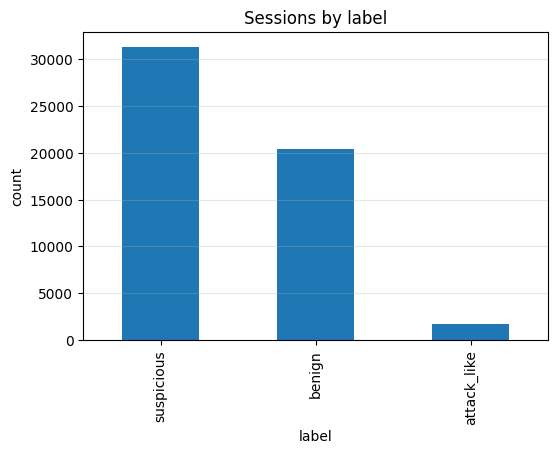

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

s = pd.read_parquet("../data/processed/sessions_scored.parquet")
vc = s["label"].value_counts()

plt.figure(figsize=(6, 4))
vc.plot(kind="bar")
plt.title("Sessions by label")
plt.ylabel("count")
plt.grid(axis="y", alpha=0.3)
plt.show()

In [11]:
from src.rag.retrieve import search_attack_for_text
import pandas as pd

s = pd.read_parquet("../data/processed/sessions_scored.parquet")
row = s[s["label"].isin(["attack_like", "suspicious"])].iloc[0]  # pick one

query = f"""
src_ip={row.src_ip} tool={row.tool} label={row.label}
event_count={row.event_count} rps={row.rps} indicator_hits={row.indicator_hits}
reasons={row.get('rule_reasons', [])}
"""

hits = search_attack_for_text(
    query, top_k=8, embed_model="BAAI/bge-large-en-v1.5", device="auto"
)
[(round(h.score, 3), h.payload["technique_id"], h.payload["name"]) for h in hits]

🔧 Embeddings device selected: cpu


Loading weights: 100%|██████████| 391/391 [00:00<00:00, 495.06it/s, Materializing param=pooler.dense.weight]                               
RobertaModel LOAD REPORT from: BAAI/bge-large-en-v1.5
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Batches: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


[(0.539, 'T1592', 'Gather Victim Host Information'),
 (0.527, 'T1595.001', 'Scanning IP Blocks'),
 (0.506, 'T1059.009', 'Cloud API'),
 (0.506, 'T1592.002', 'Software'),
 (0.505, 'T1562.006', 'Indicator Blocking'),
 (0.494, 'T1569.003', 'Systemctl'),
 (0.489, 'T1569.001', 'Launchctl'),
 (0.486, 'T1189', 'Drive-by Compromise')]